# Apple Iphone's Health app analytics

This notebook allows you to explore analyze the Iphone's health app data. First, export the data from your phone following these steps:

1. On your Iphone, open the Health app.
2. Tap the user profile pic in the top right corner of the app.
3. Scroll down and tap "Export health data".
4. Select the desired app to transfer your health data as a .zip file.
5. Unzip the .zip file in your computer.

After this, just insert the path to the unzipped folder in the variable below and run the notebook.

In [1]:
path = r'C:\Users\Eduardo\Desktop\apple_health_export'

## 1. Modules

In [2]:
import os
import xmltodict
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from matplotlib import pyplot as plt

Set graphic options

In [3]:
%matplotlib notebook
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

## 2. Import data

In [4]:
# Get XML file path
xml_file_name = os.listdir(path)[0]
xml_file_path = path + f'\{xml_file_name}'

# Open the XML file as df
with open(xml_file_path) as file:
    dict_xml   = xmltodict.parse(file.read())
    df_xml     = pd.DataFrame.from_dict(dict_xml)['HealthData']
    df_records = pd.DataFrame(df_xml['Record'])
    df_workout = pd.DataFrame(df_xml['Workout'])
    df_summary = pd.DataFrame(df_xml['ActivitySummary'])

## 3. Iphone activity analysis
This section of the code explores the main metrics from the *df_records* registered by the iPhone, which include the step count, the flights climbed and the stand time.

In [5]:
# Select desired metrics
metrics = ['HKQuantityTypeIdentifier' + x for x in ['StepCount', 'FlightsClimbed', 'AppleStandTime']]

# Keep desired metrics
df_act = df_records.loc[(df_records['@type'].isin(metrics)) & (df_records['@sourceName'] == 'iPhone')].reset_index(drop=True)

# Convert value column from string to numeric
df_act['@value'] = pd.to_numeric(arg=df_act['@value'], downcast='integer')

# Create date column as reference for grouping
df_act.insert(loc=1, column='date', value=df_act['@creationDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S %z').date()))

# Group activity by date and type
df_act = df_act.groupby(['date', '@type'])['@value'].sum().reset_index(name='value')

### 3.1. Steps

In [6]:
# Keep only step data
df_steps = df_act.loc[df_act['@type'] == 'HKQuantityTypeIdentifierStepCount']

# Weekday labels
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']

# Create a weekday column
df_steps.insert(loc=1, column='weekday', value=df_steps['date'].apply(lambda x: weekdays[x.weekday()]))

Daily step count

<IPython.core.display.Javascript object>


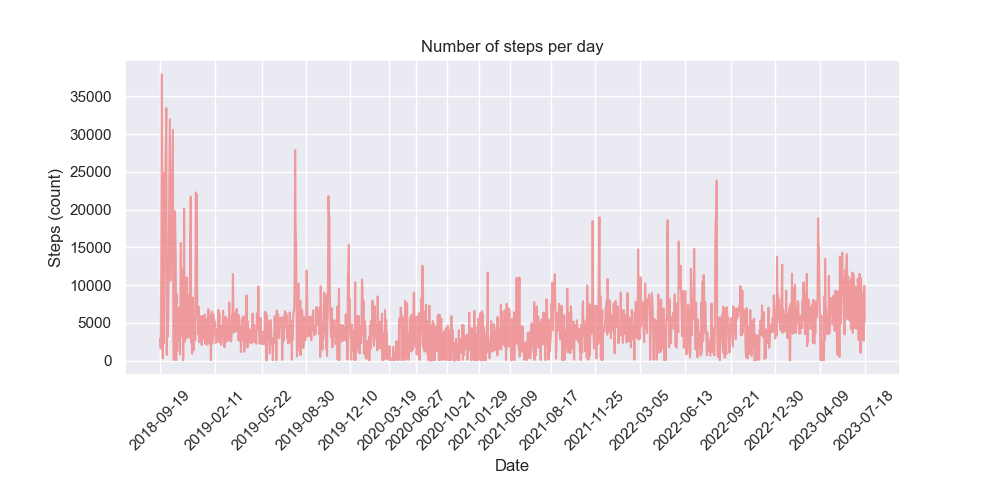

In [49]:
# Get step count
steps = df_steps['value']
dates = df_steps['date']

# Plot variables
x = steps.index
y = steps[x]
labels = dates[x]

# Plot and labelling
fig, axes = plt.subplots()
axes.plot(x, y, color='lightcoral', alpha=0.75)
axes.set_title('Number of steps per day')
axes.set_xlabel('Date')
axes.set_ylabel('Steps (count)')

# Ticks
axes.set_xticks(x[0::100])
axes.set_xticklabels(labels[0::100], rotation=45);
plt.subplots_adjust(bottom=0.25)

Step distribution per week day

<IPython.core.display.Javascript object>


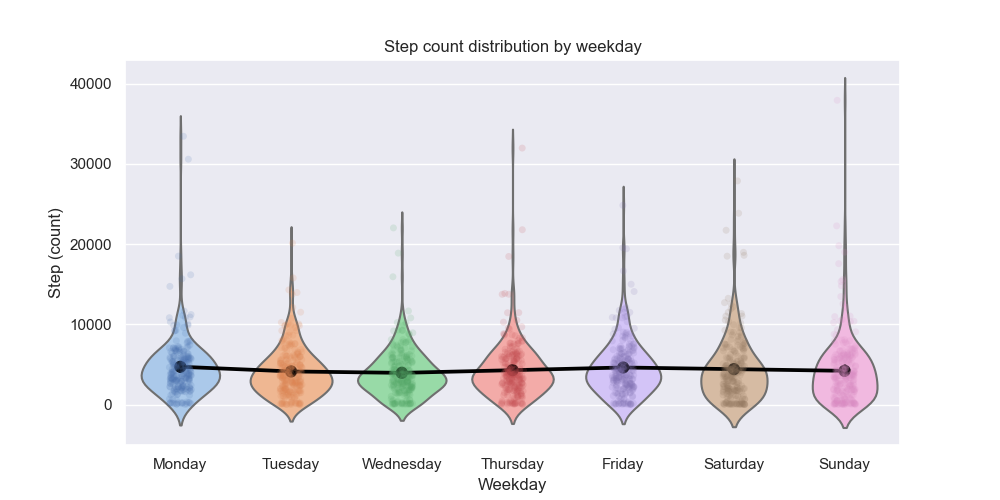

Text(0, 0.5, 'Step (count)')

In [51]:
# Plot step distribution per weekday
fig, axes = plt.subplots()
sns.violinplot(data=df_steps, x='weekday', y='value', palette='pastel', inner=None, order=weekdays, ax=axes)
sns.stripplot(data=df_steps, x='weekday', y='value', alpha=0.15, order=weekdays, ax=axes)
sns.pointplot(data=df_steps, x='weekday', y='value', estimator=np.mean, color='black', errorbar=None, order=weekdays, ax=axes)

# Labelling
axes.set_title('Step count distribution by weekday')
axes.set_xlabel('Weekday')
axes.set_ylabel('Step (count)')

In [32]:
df_steps.groupby(['weekday']).mean()

,value
weekday,
Friday,4640.483471
Monday,4729.440329
Saturday,4432.620833
Sunday,4223.036585
Thursday,4303.219008
Tuesday,4147.768293
Wednesday,3969.561983
